In [1]:
!pip install facenet_pytorch --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.1 MB/s eta 0:00:00


In [2]:
DATA_PATH = '/kaggle/input/deepfakeseqdataset10dir/'

In [3]:
import os
import random
import datetime
import sys
import itertools
import os.path
import time
import glob
import subprocess
import shutil
from pathlib import Path
from collections import Counter, defaultdict
import gc
import math
from typing import List, Dict, Tuple, Union

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from facenet_pytorch import MTCNN
from torch.nn import functional
import torchvision.models as models
import cv2


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [6]:
df = pd.read_csv(DATA_PATH + 'faces_metadata.csv')
df

,file_path,label
0,deepfake-detection/FAKE/FAKE/dfdc_train_part_9...,FAKE
1,deepfake-detection/FAKE/FAKE/dfdc_train_part_4...,FAKE
2,deepfake-detection/FAKE/FAKE/dfdc_train_part_1...,FAKE
3,deepfake-detection/FAKE/FAKE/dfdc_train_part_8...,FAKE
4,deepfake-detection/FAKE/FAKE/dfdc_train_part_1...,FAKE
...,...,...
5176,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL
5177,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL
5178,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL
5179,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL


In [7]:
!ls /kaggle/input/

deepfakeseqdataset  deepfakeseqdataset10dir


In [8]:
def convert_path(path: str) -> str:
    for i in range(10):
        path = path.replace(f'{i:02}', str(i))
    return path


def process_file_paths(df: pd.DataFrame) -> List[Tuple[str, str]]:
    result: List[Tuple[str, str]] = []

    for _, row in df.iterrows():
        file_name = row['file_path']

        file_path = file_name

        result.append((DATA_PATH + file_path, row['label']))

    return result


def get_video_info(video_path: str) -> Union[Tuple[int, float], Tuple[None, None]]:
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Не вдалося відкрити файл: {video_path}")
        return None, None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)  
    cap.release()
    
    return frame_count, fps

In [9]:
video_stats = []
result = process_file_paths(df)

for video_path, label in result:
    frame_count, fps = get_video_info(video_path)
    if frame_count is not None and fps is not None:
        video_stats.append({
            'file_path': video_path,
            'label': label,
            'frames': frame_count,
            'fps': fps
        })

df = pd.DataFrame(video_stats)

stats_fps = df['fps'].describe()
stats_frames = df['frames'].describe()

print("FPS статистика:")
print(stats_fps)

print("\nКількість кадрів статистика:")
print(stats_frames)
#df = df[df['fps'] >= 28]

FPS статистика:
count    5181.000000
mean       28.696777
std         1.617271
min        12.000000
25%        29.000000
50%        29.000000
75%        29.000000
max        30.000000
Name: fps, dtype: float64

Кількість кадрів статистика:
count    5181.0
mean       60.0
std         0.0
min        60.0
25%        60.0
50%        60.0
75%        60.0
max        60.0
Name: frames, dtype: float64


In [10]:
files_to_remove_unique = set(['avjwhrqbwl_0', 'bpqrwvichd_0', 'cctrhqvein_0', 'eupisnxhsb_0', 'gerhijzwvq_0', 'katmliewya_0', 'onoowfeded_0',
                  'pydbvfkslp_0', 'qqisdvvgfi_0', 'sclvdumbkh_0', 'snphlfsrmr_0', 'spxqkpmopb_0', 'vugbaeziku_0', 'vvtcvjvkqx_0',
                   'xuoqfchsfj_0', 'zdkyyawcwe_0', 'mshechsves_0', 'ejwvqbeyef_0', 'pqbyjmgmrk_0', 'drmtykanjz_0', 'fktxniwzxe_0',
                   'iynuflmhau_0', 'kligyzlcuk_0', 'kifzxbsnku_0', 'kifzxbsnku_0', 'euarbrmuzs_0', 'fodhjwybqm_0', 'pbpgyiimwt_0',
                   'qmqfqyqmfx_0', 'thmwcolqan_0', 'xhwacojjdg_0', 'xkwjjjkcam_0', 'zktuaqrqqv_0', 'cioizeilvz_0', 'cotvlcroov_0',
                   'tuxbzsrszr_0', 'ynpqkrmuap_0', 'gomxkjifiu_0', 'ukrckkvaqi_0', 'vlcbaytswm_0', 'wmobvmntzu_0', 'ydqeopjemz_0',
                   'cxfbhgmuyu_0', 'hqqmtxvbjj_0', 'jaetnqgktl_0', 'yurtzoovou_0', 'hlcqjuwpsd_0', 'iarobzzslu_0', 'ailmasxkxb_0',
                   'bbwrqfawrj_0', 'cefzoeryat_0', 'egcuyhyvsm_0', 'eqgipviesf_0', 'fwekcrqdak_0', 'giqncczwue_0', 'hslupphtel_0',
                   'jmqmljznhv_0', 'lkbpavasad_0', 'osqruujwxd_0', 'pjibpowymk_0', 'ptchnzeeqc_0', 'sppyyoqaey_0', 'tohrqjyter_0',
                   'xzcexrifxq_0', 'aahncigwte_0', 'fszexmwczt_0', 'fszexmwczt_0', 'lkgrqfcrps_0', 'cdgrttukjn_0', 'eclxonfxph_0',
                   'eclxonfxph_0', 'gzbagbdubm_0', 'hhhvnhhqsc_0', 'junllgghcq_0', 'qyefejorlb_0'
                  ])
files_to_remove = list(files_to_remove_unique)
#df = df[~df['file_path'].apply(lambda x: any(file in x for file in files_to_remove))]
#df

In [11]:
def df_to_list(df: pd.DataFrame) -> List[Tuple[str, str]]:
    result: List[Tuple[str, str]] = []

    for _, row in df.iterrows():
        file_name = row['file_path']

        file_path = file_name

        result.append((file_path, row['label']))

    return result


result = df_to_list(df)
#result

In [12]:
groups = defaultdict(list)
for file_path, label in result:
    base_name = os.path.basename(file_path).split('_')[0]
    groups[base_name].append((file_path, label))

single_element_groups = [group for group in groups.values() if len(group) == 1]

#single_element_groups


In [13]:
train_files = [item for group in single_element_groups for item in group]

In [14]:
#train_files

In [15]:
df = pd.DataFrame(train_files, columns=['video_path', 'label'])
#real_videos = df[df['label'] == 'REAL']
#fake_videos = df[df['label'] == 'FAKE']

#min_samples = min(len(real_videos), len(fake_videos))

#real_balanced = real_videos.sample(n=min_samples, random_state=42)
#fake_balanced = fake_videos.sample(n=min_samples, random_state=42)

#df = pd.concat([real_balanced, fake_balanced]).sample(frac=1, random_state=17)

train_data = df[~df['video_path'].str.contains('dfdc_train_part_8|dfdc_train_part_7')]
val_data = df[df['video_path'].str.contains('dfdc_train_part_8')]
test_data = df[df['video_path'].str.contains('dfdc_train_part_7')]

In [16]:
for i in range(11):
    subset_df = df[df['video_path'].str.contains(f'dfdc_train_part_{i}')]
    label_distribution = subset_df['label'].value_counts()
    print(i)
    print(label_distribution)

0
label
FAKE    150
REAL     70
Name: count, dtype: int64
1
label
FAKE    666
REAL    399
Name: count, dtype: int64
2
label
REAL    211
FAKE    164
Name: count, dtype: int64
3
label
REAL    200
FAKE    170
Name: count, dtype: int64
4
label
FAKE    170
REAL    161
Name: count, dtype: int64
5
label
REAL    320
FAKE    249
Name: count, dtype: int64
6
label
FAKE    393
REAL    391
Name: count, dtype: int64
7
label
REAL    310
FAKE    270
Name: count, dtype: int64
8
label
REAL    255
FAKE    215
Name: count, dtype: int64
9
label
REAL    262
FAKE    155
Name: count, dtype: int64
10
label
FAKE    442
REAL    294
Name: count, dtype: int64


In [17]:
#train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=17)

print("Train set size:", len(train_data))
print("Val set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 4131
Val set size: 470
Test set size: 580


In [18]:
test_data

,video_path,label
5,/kaggle/input/deepfakeseqdataset10dir/deepfake...,FAKE
12,/kaggle/input/deepfakeseqdataset10dir/deepfake...,FAKE
16,/kaggle/input/deepfakeseqdataset10dir/deepfake...,FAKE
24,/kaggle/input/deepfakeseqdataset10dir/deepfake...,FAKE
25,/kaggle/input/deepfakeseqdataset10dir/deepfake...,FAKE
...,...,...
3923,/kaggle/input/deepfakeseqdataset10dir/deepfake...,REAL
3924,/kaggle/input/deepfakeseqdataset10dir/deepfake...,REAL
3925,/kaggle/input/deepfakeseqdataset10dir/deepfake...,REAL
3926,/kaggle/input/deepfakeseqdataset10dir/deepfake...,REAL


In [19]:
#real_videos = train_data[train_data['label'] == 'REAL']
#fake_videos = train_data[train_data['label'] == 'FAKE']

#min_samples = min(len(real_videos), len(fake_videos))

#real_balanced = real_videos.sample(n=min_samples, random_state=42)
#fake_balanced = fake_videos.sample(n=min_samples, random_state=42)

#train_data = pd.concat([real_balanced, fake_balanced]).sample(frac=1, random_state=17)
#train_data

<Axes: >

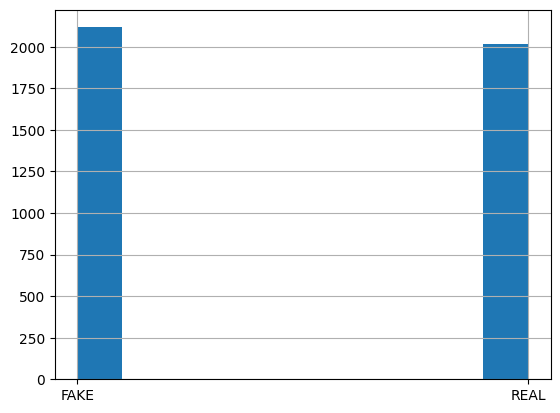

In [20]:
train_data['label'].hist()

<Axes: >

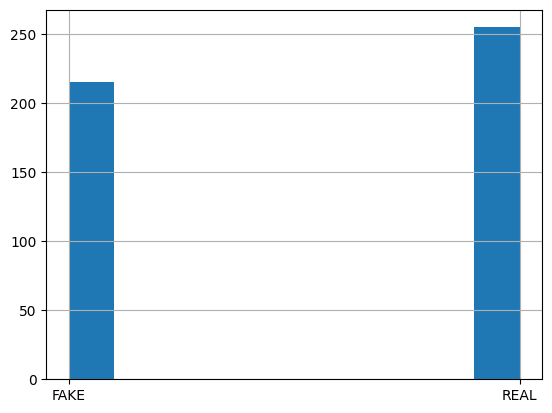

In [21]:
val_data['label'].hist()

<Axes: >

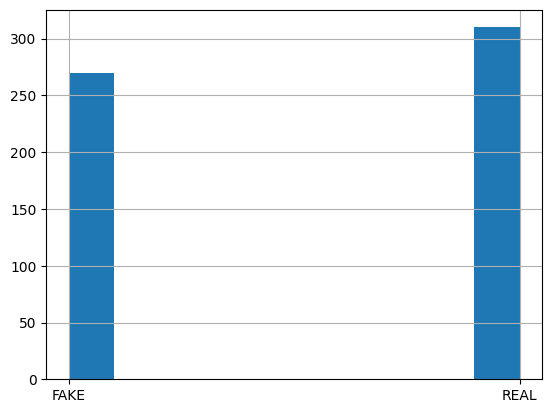

In [22]:
test_data['label'].hist()

In [23]:
print("Train set size:", len(train_data))
print("Val set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 4131
Val set size: 470
Test set size: 580


In [24]:
train_data.to_csv("train_dataset.csv", index=False)
val_data.to_csv("val_dataset.csv", index=False)
test_data.to_csv("test_dataset.csv", index=False)

In [25]:
def create_json_from_csv(input_csv: str, output_json: str) -> None:
    df = pd.read_csv(input_csv)
    result: Dict[str, str] = {}

    for _, row in df.iterrows():
        file_path = row['video_path']
        label = row['label']

        result[file_path] = {'label': label}

    with open(output_json, 'w') as json_file:
        json.dump(result, json_file, indent=4)


create_json_from_csv('train_dataset.csv', 'output_balenced_train.json')
create_json_from_csv('val_dataset.csv', 'output_balenced_val.json')
create_json_from_csv('test_dataset.csv', 'output_balenced_test.json')

In [26]:
with open('output_balenced_train.json', 'r') as json_file:
    data = json.load(json_file)

label_counts = Counter()

for item in data.values():
    label_counts[item['label']] += 1

for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: FAKE, Count: 2117
Label: REAL, Count: 2014


In [27]:
from torchvision import transforms


class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, n_frames: int, df_path: str, device, cache_folder: str, image_size=(224, 224), transform=None):

        self.n_frames = n_frames
        self.videos = []
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.image_size = image_size
        
        self.transform = transform
        
        self.detector = MTCNN(device=device, post_process=False)

        with open(df_path) as f:
            videos = json.load(f)
            videos = [(video, metadata) for (video, metadata) in videos.items()]
            self.videos += videos

    def __getitem__(self, n):
        video, metadata = self.videos[n]
        video_id = os.path.splitext(os.path.basename(video))[0]
        cap = cv2.VideoCapture(video)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Загальна кількість кадрів у відео
        start_frame = random.randint(0, max(0, total_frames - self.n_frames))  # Випадковий стартовий кадр

        # Перемотка до стартового кадру
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        frames = []

        for _ in range(self.n_frames):
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resize = (self.image_size[0], self.image_size[1])
            frame = cv2.resize(frame, resize)
            frame = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
            frames.append(frame)

        cap.release()

        frames = torch.stack(frames).to(self.device)
        
        if self.transform:
            frames = self.transform(frames)

        label = 0.0
        if metadata['label'] == 'FAKE':
            label = 1.0

        return frames, torch.FloatTensor([label]).to(self.device)


    def __len__(self):
        return len(self.videos)

    
class SameAugmentation:
    def __init__(self, augmentations):
        """
        Args:
            augmentations (callable): Трансформації, що застосовуються до всіх кадрів.
        """
        self.augmentations = augmentations

    def __call__(self, frames):
        # Ініціалізуємо однакове перетворення
        seed = torch.randint(0, 2**32, (1,)).item()

        # Застосовуємо однакові трансформації до всіх кадрів
        augmented_frames = []
        for frame in frames:
            torch.manual_seed(seed)  # Встановлюємо однаковий seed
            augmented_frames.append(self.augmentations(frame))
        
        return torch.stack(augmented_frames)

Label: tensor([1.], device='cuda:0')


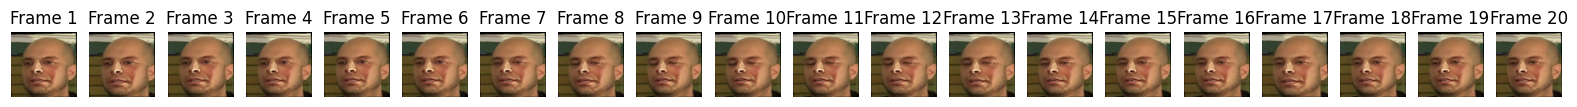

In [28]:
def test_train_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transfor = SameAugmentation(
        transforms.Compose([
            # Горизонтальне відображення
            transforms.RandomHorizontalFlip(p=0.5),
            # Легке афінне перетворення
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            # Легкий поворот
            transforms.RandomRotation(degrees=5, fill=0),
            # Розмиття для імітації відео низької якості
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
            # Колірні зміни (яскравість, контраст)
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            # Перетворення в сірий для певного шуму
            transforms.RandomGrayscale(p=0.1),
        ])
    )
    
    dataset = VideoDataset(20, 'output_balenced_train.json', device, 'cache', (224, 224), transfor)

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([20, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 20, figsize=(20, 10))

        for j in range(20):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_train_data()

Label: tensor([1.], device='cuda:0')


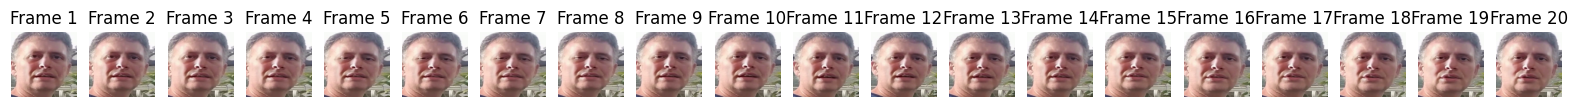

In [29]:
def test_test_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = VideoDataset(20, 'output_balenced_test.json', device, 'cache', (224, 224), None)

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([20, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 20, figsize=(20, 10))

        for j in range(20):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_test_data()

In [34]:
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()


def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    
    minposs = val_losses.index(min(val_losses)) 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


def plot_confusion_matrix_final(all_labels, all_preds, title):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

In [35]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [43]:
def train_model(model, hparms: dict[str, Union[int, float]], path_train: str, path_test: str, size: tuple[int], device, name: str, checkpoint_path: str = None):
    batch_size = hparms['batch_size']
    num_epochs = hparms['num_epochs']
    n_frames = hparms['n_frames']
    lr = hparms['lr']

    gamma = hparms['gamma']
    milestones = hparms['milestones']

    model.to(device)
    
    early_stopping = EarlyStopping(patience=15, verbose=True, delta=0.0001, path=f'early_stopping_{name}_lstm_checkpoint.pt')

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    
    transfor_train = SameAugmentation(
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomRotation(degrees=5, fill=0),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            transforms.RandomGrayscale(p=0.1),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    )
    
    transfor = SameAugmentation(
        transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    )

    train_dataset = VideoDataset(n_frames, path_train, device, 'cache', size, transfor_train)
    test_dataset = VideoDataset(n_frames, path_test, device, 'cache', size, transfor)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    start_time = datetime.datetime.now()
    print(f'Start time: {start_time}, using device: {device}')

    best_loss = np.inf
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
    else:
        start_epoch = 0

    for epoch in range(start_epoch, num_epochs):
        epoch_start_time = time.time()
        epoch_t_loss, epoch_v_loss = 0, 0
        t_count, t_count_wrong = 0, 0
        all_train_labels, all_train_preds = [], []
        test_probs = []

        model.train()

        for video_data, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", leave=False):
            video_data, labels = video_data.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(video_data)
            
            loss = criterion(output, labels)

            epoch_t_loss += loss.item()
            output = torch.sigmoid(output).round()
            n_wrong = (labels - output).abs().sum().item()
            t_count_wrong += n_wrong
            t_count += labels.shape[0]

            all_train_labels.extend(labels.detach().cpu().numpy())
            all_train_preds.extend(output.detach().cpu().numpy())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        train_loss = epoch_t_loss / len(train_loader)
        train_accuracy = (t_count - t_count_wrong) / t_count
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        
        all_val_labels, all_val_preds = [], []
        with torch.no_grad():
            for video_data, labels in tqdm(val_loader, desc="Validation", leave=False):
                video_data, labels = video_data.to(device), labels.to(device)

                output = model(video_data)
                output_probs = torch.sigmoid(output)
                test_probs.extend(output_probs.cpu().numpy())
                
                loss = criterion(output, labels)
                epoch_v_loss += loss.item()

                output = torch.sigmoid(output).round()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(output.cpu().numpy())

        val_loss = epoch_v_loss / len(val_loader)
        val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_exec_time = time.time() - epoch_start_time
        epoch_times.append(epoch_exec_time)
        print(f'Epoch {epoch + 1}/{num_epochs} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
        print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}, Time: {epoch_exec_time:.2f}s')
        val_auc = roc_auc_score(all_val_labels, test_probs)
        print(f'Validation AUC: {val_auc}')
        
        scheduler.step()

        torch.save({
                    'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'scheduler_state_dict': scheduler.state_dict(),
                      'epoch': epoch + 1
                      }, f'best_{name}_lstm_checkpoint_epoch_{epoch + 1}.pt'
        )
        
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print(f'Training completed in: {str(datetime.datetime.now() - start_time)}')

    plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    print("Train Classification Report:")
    print(classification_report(all_train_labels, all_train_preds))
    plot_confusion_matrix_final(all_train_labels, all_train_preds, 'Train')

    print("Validation Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Validation')
    val_auc = roc_auc_score(all_val_labels, test_probs)
    print(f'Validation AUC: {val_auc}')

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np


class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(
            block=models.resnet.Bottleneck,
            layers=[3, 4, 6, 3],
            groups=32,
            width_per_group=4
        )
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)
        self.fc = nn.Identity()


class SelfAttention(nn.Module):
    def __init__(self, lstm_hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.key = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.value = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_scores = torch.bmm(query, key.transpose(1, 2)) / (query.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)
        attention_weights = self.dropout(attention_weights)

        attended_values = torch.bmm(attention_weights, value)
        return attended_values


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class ResNetLSTMClassifier(nn.Module):
    def __init__(self, n_linear_hidden, lstm_hidden_dim, num_lstm_layers,
                 dropout, bidirectional, freeze):
        super(ResNetLSTMClassifier, self).__init__()

        self.cnn = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        self.feature_output_size = 2048

        if freeze:
            self.freeze_until("layer4.0.conv1.weight")

        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-1],
        )

        self.lstm = nn.LSTM(
            input_size=self.feature_output_size,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            dropout=0.1,
            batch_first=True,
            bidirectional=bidirectional
        )

        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim * (2 if bidirectional else 1), lstm_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_dim // 2, 1),
        )

        self.target_layer1 = self.feature_extractor[-2][2].conv3
        
        self.activations = {}
        self.gradients = {}

        self.target_layer1.register_forward_hook(self.save_activations_hook("layer1"))
        self.target_layer1.register_backward_hook(self.save_gradients_hook("layer1"))

    def save_activations_hook(self, layer_name):
        def hook(module, input, output):
            self.activations[layer_name] = output
        return hook

    def save_gradients_hook(self, layer_name):
        def hook(module, grad_input, grad_output):
            self.gradients[layer_name] = grad_output[0]
        return hook

    def freeze_until(self, param_name):
        found = False
        for name, param in self.cnn.named_parameters():
            if name == param_name:
                found = True
            param.requires_grad = found

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        vid_features = self.feature_extractor(vid_frames)  # (batch_size*num_frames, feature_output_size, 1, 1)

        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        lstm_out, _ = self.lstm(vid_features)  # (batch_size, num_frames, lstm_hidden_dim)

        output = self.classifier(lstm_out[:, -1, :])

        return output

In [47]:
def initialize_lstm_weights(model):
    for name, param in model.lstm.named_parameters():
        if 'weight_ih' in name:
            nn.init.xavier_uniform_(param)
        elif 'weight_hh' in name:
            nn.init.orthogonal_(param)
        elif 'bias' in name:
            nn.init.zeros_(param)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 187MB/s]


Training ResNetLSTMNoBiClassifier20x224 model:
Hyperparameters {'n_linear_hidden': 64, 'lstm_hidden_dim': 64, 'num_lstm_layers': 2, 'dropout': 0.4, 'bidirectional': False, 'freeze': False, 'n_frames': 20, 'batch_size': 4, 'lr': 1e-05, 'num_epochs': 25, 'gamma': 0.1, 'milestones': [32, 64]}
Start time: 2025-02-23 09:18:07.033967, using device: cuda


Epoch 1/25 - Train loss: 0.6797, Train accuracy: 0.5752
Validation loss: 0.6603, Validation accuracy: 0.6745, Time: 1147.55s
Validation AUC: 0.7248335613315094
Validation loss decreased (inf --> 0.660329).  Saving model ...


Epoch 2/25 - Train loss: 0.6333, Train accuracy: 0.6952
Validation loss: 0.6324, Validation accuracy: 0.6660, Time: 1128.92s
Validation AUC: 0.7361969904240766
Validation loss decreased (0.660329 --> 0.632391).  Saving model ...


Epoch 3/25 - Train loss: 0.5736, Train accuracy: 0.7434
Validation loss: 0.5957, Validation accuracy: 0.6979, Time: 1125.01s
Validation AUC: 0.7869585043319653
Validation loss decreased (0.632391 --> 0.595657).  Saving model ...


Epoch 4/25 - Train loss: 0.5257, Train accuracy: 0.7766
Validation loss: 0.6058, Validation accuracy: 0.6957, Time: 1125.47s
Validation AUC: 0.7900592795257638
EarlyStopping counter: 1 out of 15


Epoch 5/25 - Train loss: 0.4956, Train accuracy: 0.7957
Validation loss: 0.6828, Validation accuracy: 0.6745, Time: 1125.82s
Validation AUC: 0.7233014135886913
EarlyStopping counter: 2 out of 15


Epoch 6/25 - Train loss: 0.4699, Train accuracy: 0.8165
Validation loss: 0.4597, Validation accuracy: 0.8149, Time: 1123.52s
Validation AUC: 0.8582580939352485
Validation loss decreased (0.595657 --> 0.459691).  Saving model ...


Epoch 7/25 - Train loss: 0.4440, Train accuracy: 0.8364
Validation loss: 0.5431, Validation accuracy: 0.7809, Time: 1120.73s
Validation AUC: 0.8566347469220246
EarlyStopping counter: 1 out of 15


Epoch 8/25 - Train loss: 0.4250, Train accuracy: 0.8485
Validation loss: 0.6132, Validation accuracy: 0.7638, Time: 1126.27s
Validation AUC: 0.8672138622891017
EarlyStopping counter: 2 out of 15


Epoch 9/25 - Train loss: 0.3963, Train accuracy: 0.8644
Validation loss: 0.7260, Validation accuracy: 0.7362, Time: 1125.63s
Validation AUC: 0.8348290013679891
EarlyStopping counter: 3 out of 15


Epoch 10/25 - Train loss: 0.3786, Train accuracy: 0.8727
Validation loss: 0.8160, Validation accuracy: 0.7255, Time: 1126.86s
Validation AUC: 0.8194072047423621
EarlyStopping counter: 4 out of 15


Epoch 11/25 - Train loss: 0.3619, Train accuracy: 0.8870
Validation loss: 0.7626, Validation accuracy: 0.7574, Time: 1126.87s
Validation AUC: 0.8354582763337893
EarlyStopping counter: 5 out of 15


Epoch 12/25 - Train loss: 0.3492, Train accuracy: 0.8906
Validation loss: 0.8921, Validation accuracy: 0.7255, Time: 1127.63s
Validation AUC: 0.8063018695850434
EarlyStopping counter: 6 out of 15


Epoch 13/25 - Train loss: 0.3403, Train accuracy: 0.8983
Validation loss: 1.0563, Validation accuracy: 0.7064, Time: 1125.12s
Validation AUC: 0.7860282717738258
EarlyStopping counter: 7 out of 15


Epoch 14/25 - Train loss: 0.3070, Train accuracy: 0.9099
Validation loss: 1.0213, Validation accuracy: 0.7213, Time: 1125.77s
Validation AUC: 0.8183857729138168
EarlyStopping counter: 8 out of 15


Epoch 15/25 - Train loss: 0.3122, Train accuracy: 0.9124
Validation loss: 0.7263, Validation accuracy: 0.8064, Time: 1127.30s
Validation AUC: 0.8875877792977656
EarlyStopping counter: 9 out of 15


Epoch 16/25 - Train loss: 0.2924, Train accuracy: 0.9233
Validation loss: 1.0302, Validation accuracy: 0.7383, Time: 1126.84s
Validation AUC: 0.8010670314637482
EarlyStopping counter: 10 out of 15


Epoch 17/25 - Train loss: 0.2662, Train accuracy: 0.9325
Validation loss: 0.7020, Validation accuracy: 0.8234, Time: 1126.64s
Validation AUC: 0.8991883264933881
EarlyStopping counter: 11 out of 15


Epoch 18/25 - Train loss: 0.2695, Train accuracy: 0.9313
Validation loss: 1.2255, Validation accuracy: 0.7085, Time: 1125.59s
Validation AUC: 0.8288919288645691
EarlyStopping counter: 12 out of 15


Epoch 19/25 - Train loss: 0.2597, Train accuracy: 0.9339
Validation loss: 1.3515, Validation accuracy: 0.6894, Time: 1128.45s
Validation AUC: 0.8452530779753761
EarlyStopping counter: 13 out of 15


Epoch 20/25 - Train loss: 0.2613, Train accuracy: 0.9356
Validation loss: 1.3806, Validation accuracy: 0.7000, Time: 1128.27s
Validation AUC: 0.8156041951664386
EarlyStopping counter: 14 out of 15


Epoch 21/25 - Train loss: 0.2497, Train accuracy: 0.9400
Validation loss: 1.2785, Validation accuracy: 0.7255, Time: 1126.57s
Validation AUC: 0.8637118103055175
EarlyStopping counter: 15 out of 15
Early stopping
Training completed in: 6:34:40.886416


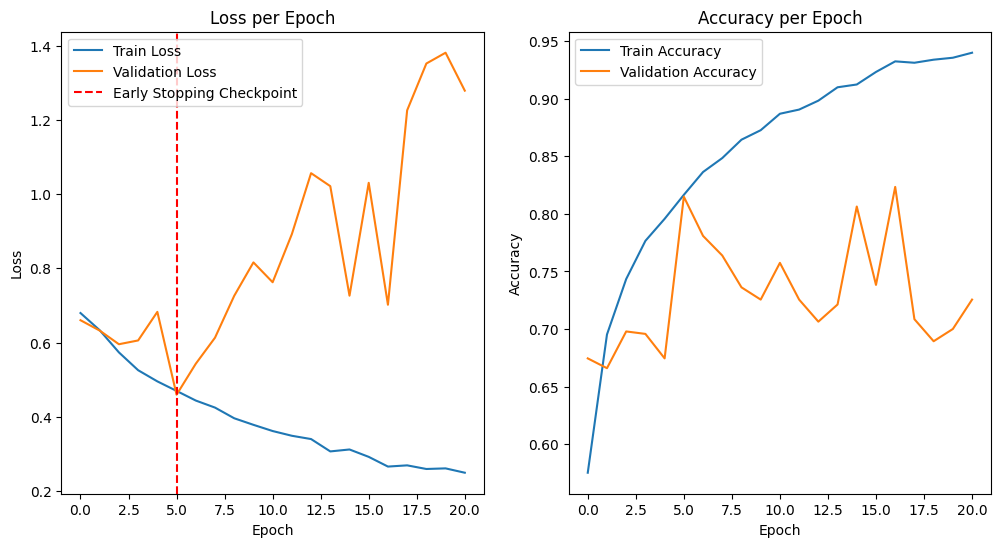

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      2014
         1.0       0.94      0.94      0.94      2117

    accuracy                           0.94      4131
   macro avg       0.94      0.94      0.94      4131
weighted avg       0.94      0.94      0.94      4131



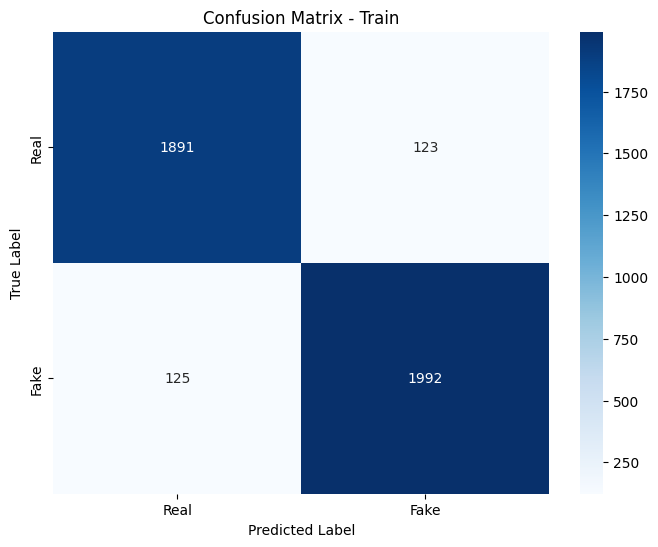

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.57      0.69       255
         1.0       0.64      0.91      0.75       215

    accuracy                           0.73       470
   macro avg       0.76      0.74      0.72       470
weighted avg       0.77      0.73      0.72       470



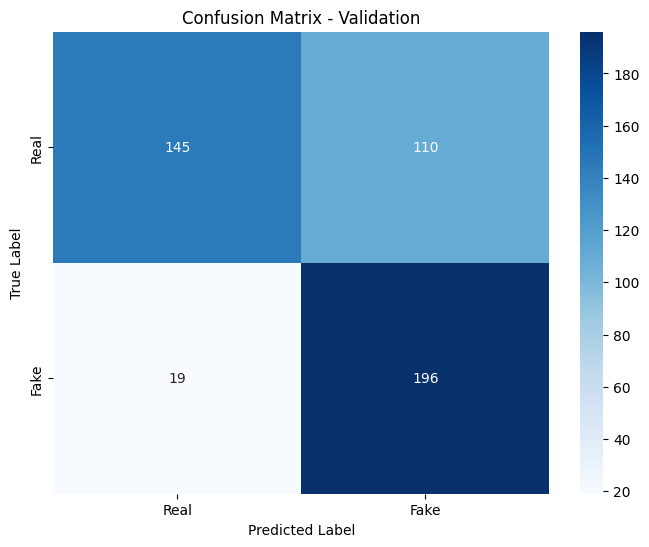

Validation AUC: 0.8637118103055175


In [48]:
hyperparameters_1: dict[str: Union[int, float, list]] = {
    'n_linear_hidden': 64,
    'lstm_hidden_dim': 64,
    'num_lstm_layers': 2,
    'dropout': 0.4,
    'bidirectional': False,
    'freeze': False,
    'n_frames': 20,
    'batch_size': 4,
    'lr': 0.00001,
    'num_epochs': 25,
    'gamma': 0.1,
    'milestones': [32, 64]
}

models_to_train = [
    (ResNetLSTMClassifier, 'ResNetLSTMNoBiClassifier20x224', (224, 224), hyperparameters_1)
]

for model_type, name, size, hyperparameters in models_to_train:
    model = model_type(
        n_linear_hidden=hyperparameters['n_linear_hidden'],
        lstm_hidden_dim=hyperparameters['lstm_hidden_dim'],
        num_lstm_layers=hyperparameters['num_lstm_layers'],
        dropout=hyperparameters['dropout'],
        bidirectional=hyperparameters['bidirectional'],
        freeze=hyperparameters['freeze']
    )
    initialize_lstm_weights(model)
    
    print(f'Training {name} model:')
    print('Hyperparameters', hyperparameters)
    trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_model(model, hyperparameters, 'output_balenced_train.json', 'output_balenced_val.json', size, device, name)

In [49]:
def test_model(model: nn.Module, data_path: str, n_frames: int, size: Tuple[int, int]):
    batch_size = 1
    epoch_v_loss = 0
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()

    transfor = SameAugmentation(
        transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    )

    test_dataset = VideoDataset(n_frames, data_path, device, 'cache', size, transfor)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model.eval()
    torch.cuda.empty_cache()
    gc.collect()
    
    all_val_labels, all_val_preds = [], []
    test_probs = []
    with torch.no_grad():
        for video_data, labels in tqdm(test_loader, desc="Test", leave=False):
            video_data, labels = video_data.to(device), labels.to(device)

            output = model(video_data)
            output_probs = torch.sigmoid(output)
            test_probs.extend(output_probs.cpu().numpy())

            loss = criterion(output, labels)
            epoch_v_loss += loss.item()

            output = torch.sigmoid(output).round()
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(output.cpu().numpy())

            torch.cuda.empty_cache()
            gc.collect()
        
    val_loss = epoch_v_loss / len(test_loader)
    val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)

    print(f'Test loss: {val_loss:.4f}, Test accuracy: {val_accuracy:.4f}')

    print("Test Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Test')
    val_auc = roc_auc_score(all_val_labels, test_probs)
    print(f'Test AUC: {val_auc}')

Test loss: 1.5583, Test accuracy: 0.6621
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.49      0.61       310
         1.0       0.59      0.86      0.70       270

    accuracy                           0.66       580
   macro avg       0.70      0.68      0.66       580
weighted avg       0.71      0.66      0.65       580



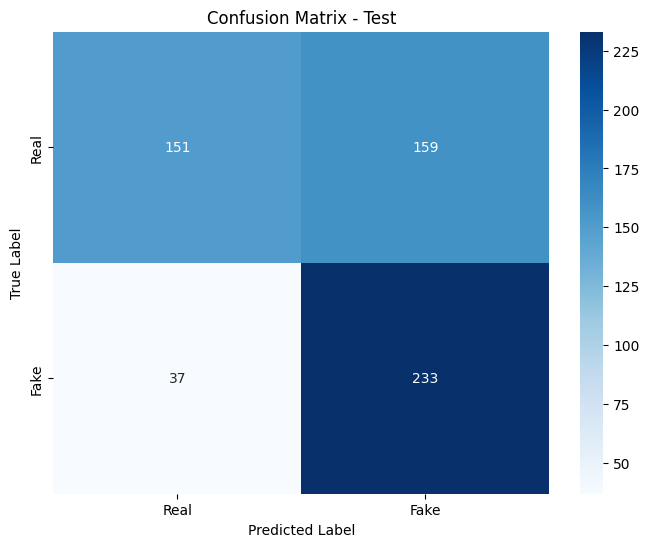

Test AUC: 0.7775388291517324


8163

In [50]:
test_model(model, 'output_balenced_test.json', 20, (224, 224))
del model
torch.cuda.empty_cache()
gc.collect()

Test loss: 0.6375, Test accuracy: 0.7241
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73       310
         1.0       0.69      0.74      0.71       270

    accuracy                           0.72       580
   macro avg       0.72      0.73      0.72       580
weighted avg       0.73      0.72      0.72       580



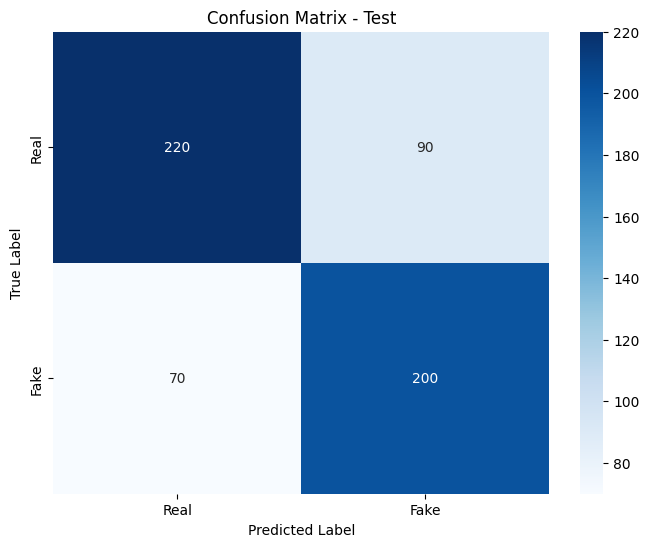

Test AUC: 0.7567144563918758


In [51]:
model_path = '/kaggle/working/early_stopping_ResNetLSTMNoBiClassifier20x224_lstm_checkpoint.pt'
    
model = ResNetLSTMClassifier(
    n_linear_hidden=hyperparameters_1['n_linear_hidden'],
    lstm_hidden_dim=hyperparameters_1['lstm_hidden_dim'],
    num_lstm_layers=hyperparameters_1['num_lstm_layers'],
    dropout=hyperparameters_1['dropout'],
    bidirectional=hyperparameters_1['bidirectional'],
    freeze=hyperparameters_1['freeze']
)
checkpoint = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint)

test_model(model, 'output_balenced_test.json', 20, (224, 224))